In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 4 - Lorenz-like System

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [101]:
# Required variables
alpha = 1./1000.
beta = 8.0/3.0
sigma = 10.

# Time variables
dt = 1.0 / 8
t_max = 250
t_vec = np.arange(0, t_max + dt, dt)

r = 10.0 * dt
N = 2000

T = 1
omega = 1./T
offset = 50

scenarios = ['2xCO2','High Emissions','Overshoot']

x_snap, y_snap, z_snap, z_mean, z_max, z_std, rho = {}, {}, {}, {}, {}, {}, {}
for i, scen in enumerate(scenarios):
  x_snap[scen], y_snap[scen], z_snap[scen], z_mean[scen], z_max[scen], z_std[scen], rho[scen] = emulator_utils.Lorenz_integrate(t_max, dt, N, r, alpha, beta, sigma, omega, offset, exp=i)

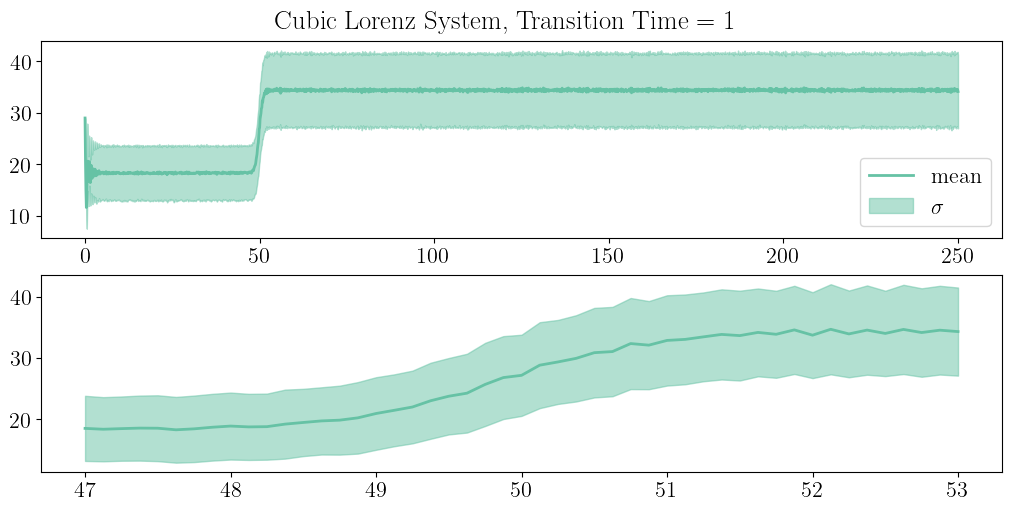

In [102]:
scen = scenarios[0]
emulator_utils.Lorenz_plot(z_mean[scen], z_std[scen], t_vec, offset, T)

In [111]:
G_FDT, z_pert, z_vec = emulator_utils.Lorenz_integrate(t_max, dt, N, r, alpha, beta, sigma, omega, offset, exp=0, FDT=True)

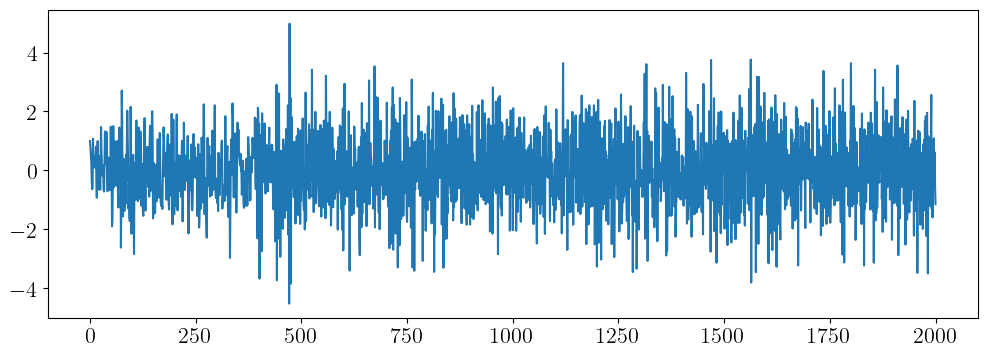

In [112]:
plt.plot(G_FDT.T)

In [113]:
response = emulator_utils.emulate_response(rho['Overshoot'], G_FDT, dt)

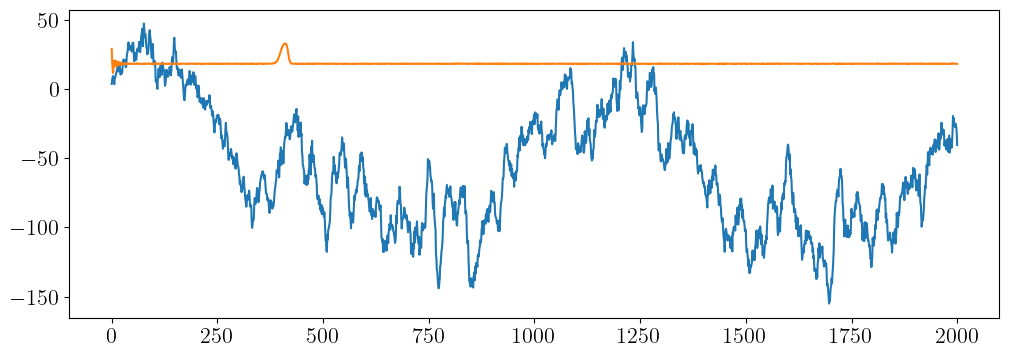

In [114]:
plt.plot(response)
plt.plot(z_mean['Overshoot'])

### Method X: DMD

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [18.82371981]
	Test: High Emissions - [15.93563936]
	Test: Overshoot - [26.9656397]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [16.90248883]
	Test: High Emissions - [13.87435246]
	Test: Overshoot - [28.8164506]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [55.24673689]
	Test: High Emissions - [50.12220915]
	Test: Overshoot - [7.51539775]


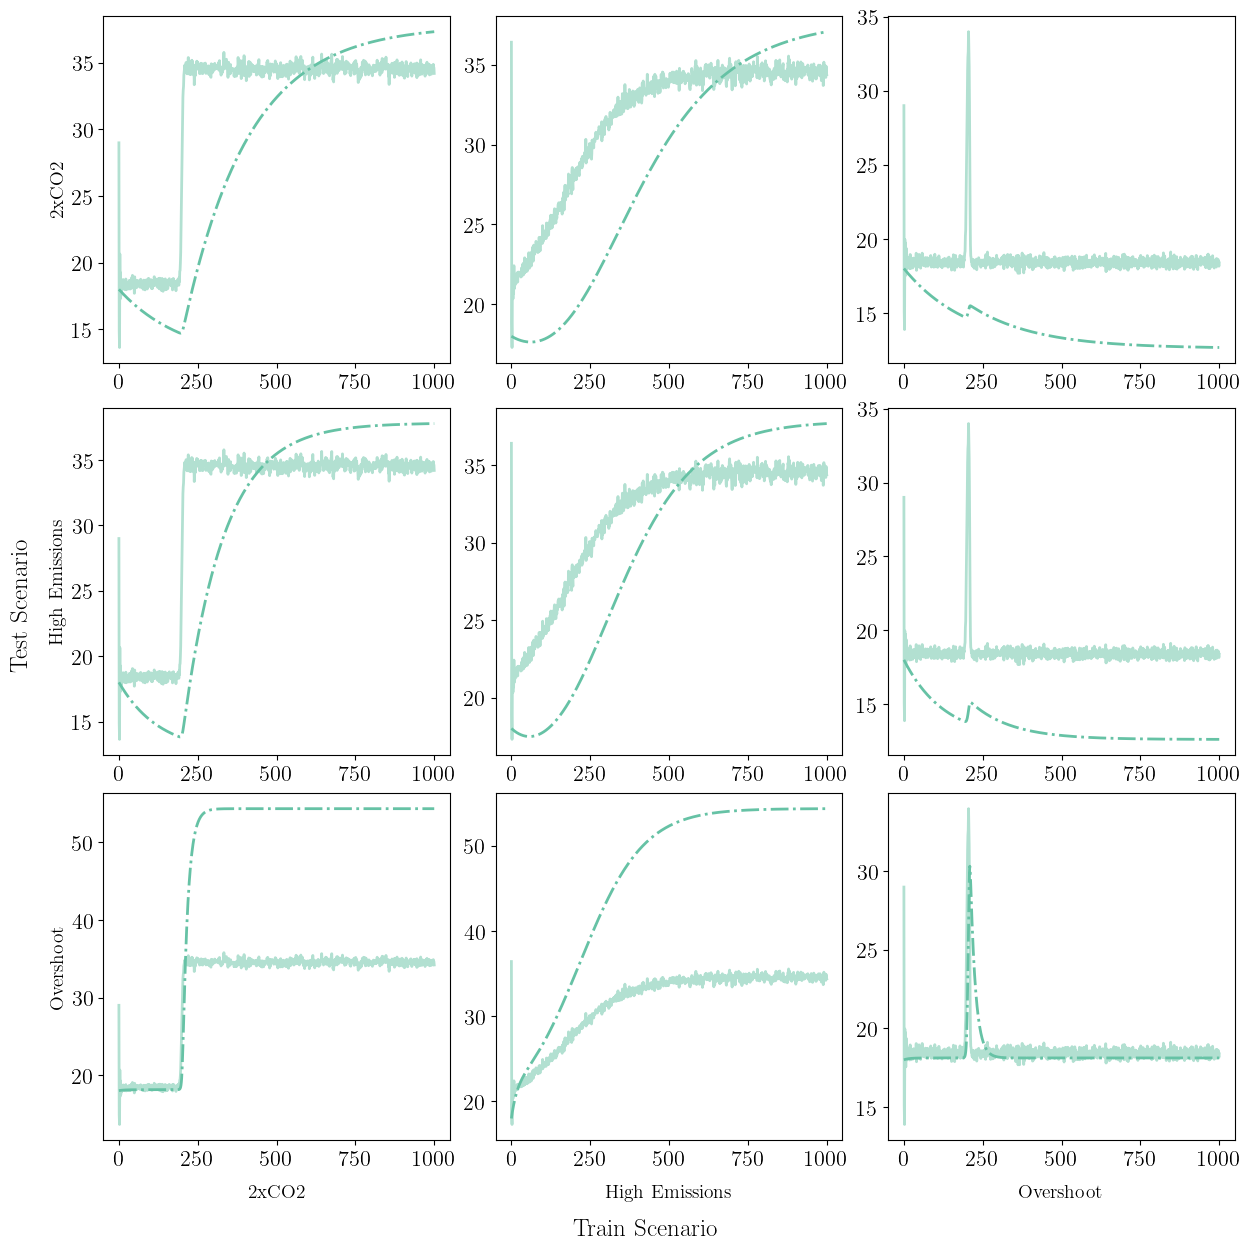

In [97]:
n_steps = len(t_vec)
n_boxes = 1
w0 = np.ones(n_boxes)*18
#dt = 1
t_range = np.where(t_vec > 0)[0]
operator_DMD, z_pred_DMD, error_metrics_DMD = emulator_utils.emulate_scenarios('DMD', scenarios=scenarios, outputs=z_mean, forcings=rho, w0=w0, t=t_vec, dt=dt, n_steps=n_steps, n_boxes=n_boxes, t_range=t_range)
emulator_utils.plot_true_pred(z_mean, z_pred_DMD, scenarios)

### Method X: EDMD

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [1.66962467]
	Test: High Emissions - [2.64583768]
	Test: Overshoot - [2.71823512]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [1.71818798]
	Test: High Emissions - [2.18017239]
	Test: Overshoot - [2.73709346]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [2.2766593]
	Test: High Emissions - [2.4685819]
	Test: Overshoot - [2.55520448]


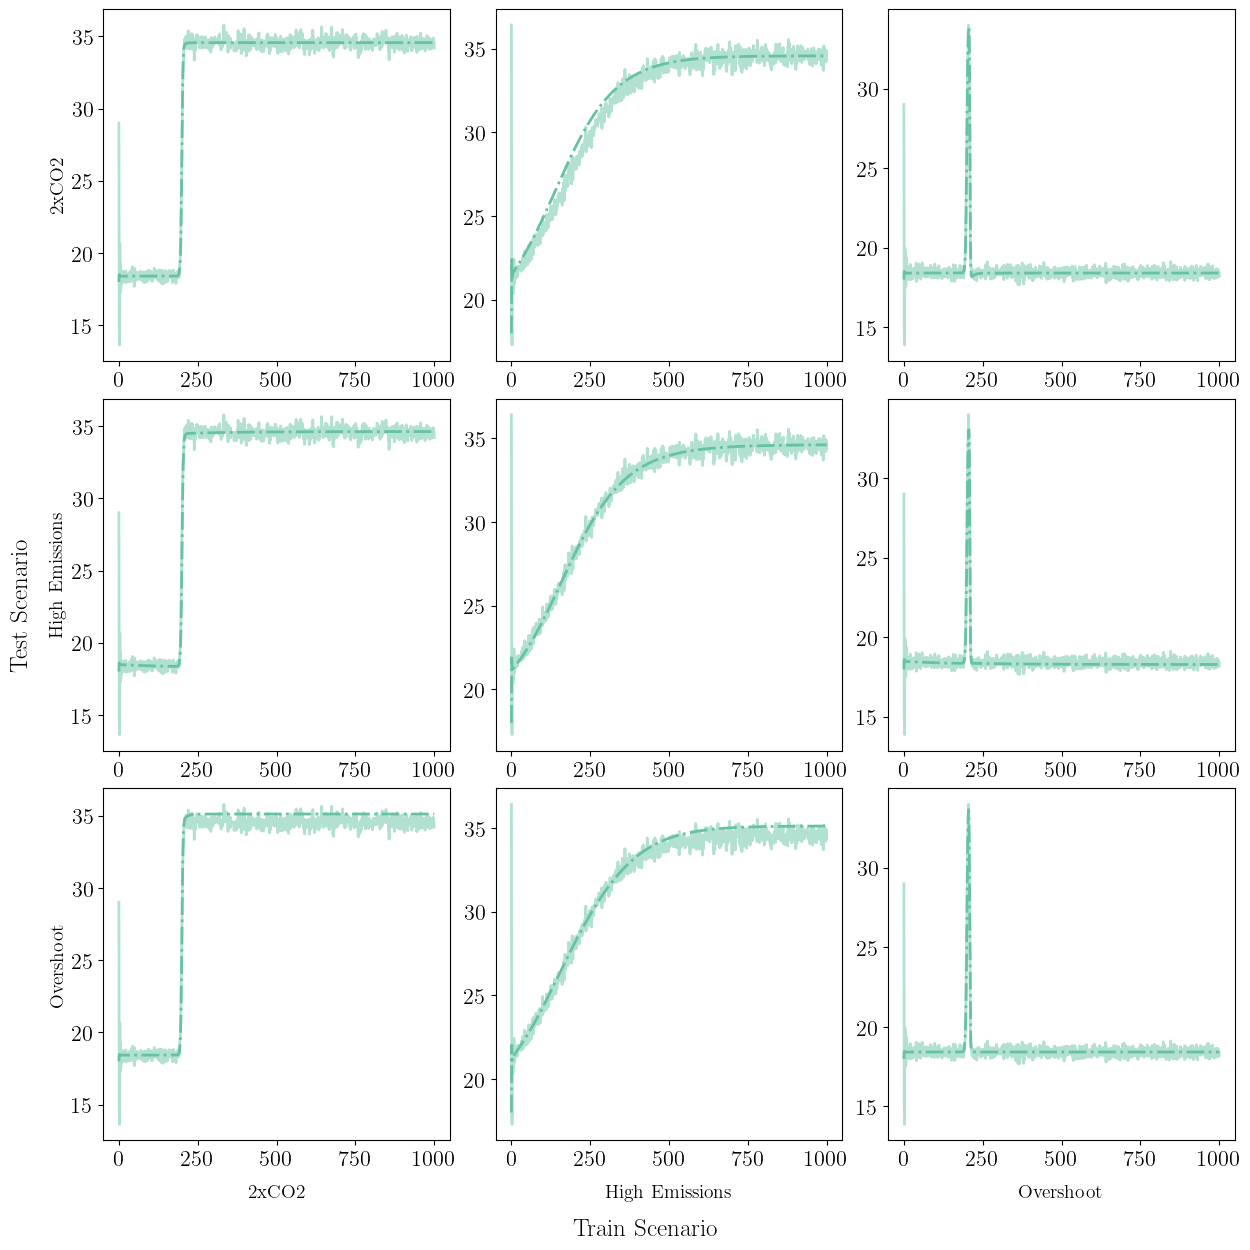

In [98]:
n_steps = len(t_vec)
w0 = np.ones(n_boxes)*18
dt = 1
w_dict = emulator_utils.Vector_Dict(method='hermite', degree=3)
F_dict = emulator_utils.Vector_Dict(method='hermite', degree=3)

#w_dict = emulator_utils.Vector_Dict(method='damped_osc', alpha=1, omega=1)
#F_dict = emulator_utils.Vector_Dict(method='damped_osc', alpha=1, omega=1)

t_range = np.where(t_vec > 50)[0]
operator_EDMD, T_pred_EDMD, L2_EDMD = emulator_utils.emulate_scenarios('EDMD', scenarios=scenarios, outputs=z_mean, forcings=rho, w0=w0, t=t_vec, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
emulator_utils.plot_true_pred(z_mean, T_pred_EDMD, scenarios)

### Method X: Deconvolution

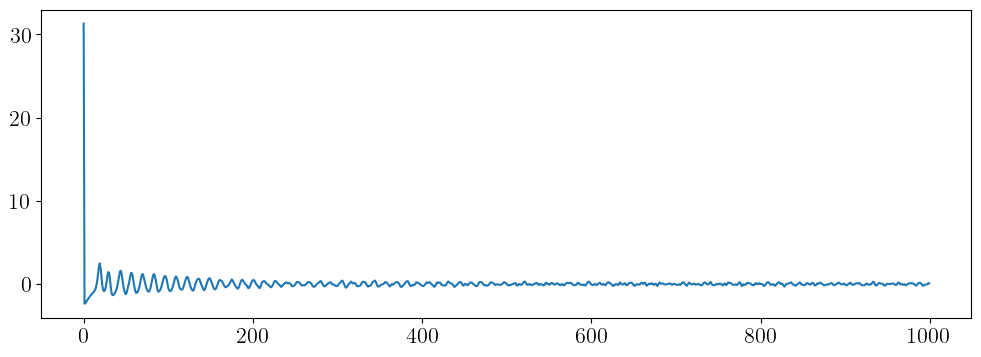

In [89]:
plt.plot(operator_deconvolve['High Emissions'].T[0:1000])

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [1.26442844e-13]
	Test: High Emissions - [212.2075677]
	Test: Overshoot - [285.92625284]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [12.39977568]
	Test: High Emissions - [1.40297163e-13]
	Test: Overshoot - [35.54057713]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [69.68639365]
	Test: High Emissions - [82.25881527]
	Test: Overshoot - [1.34573697e-13]


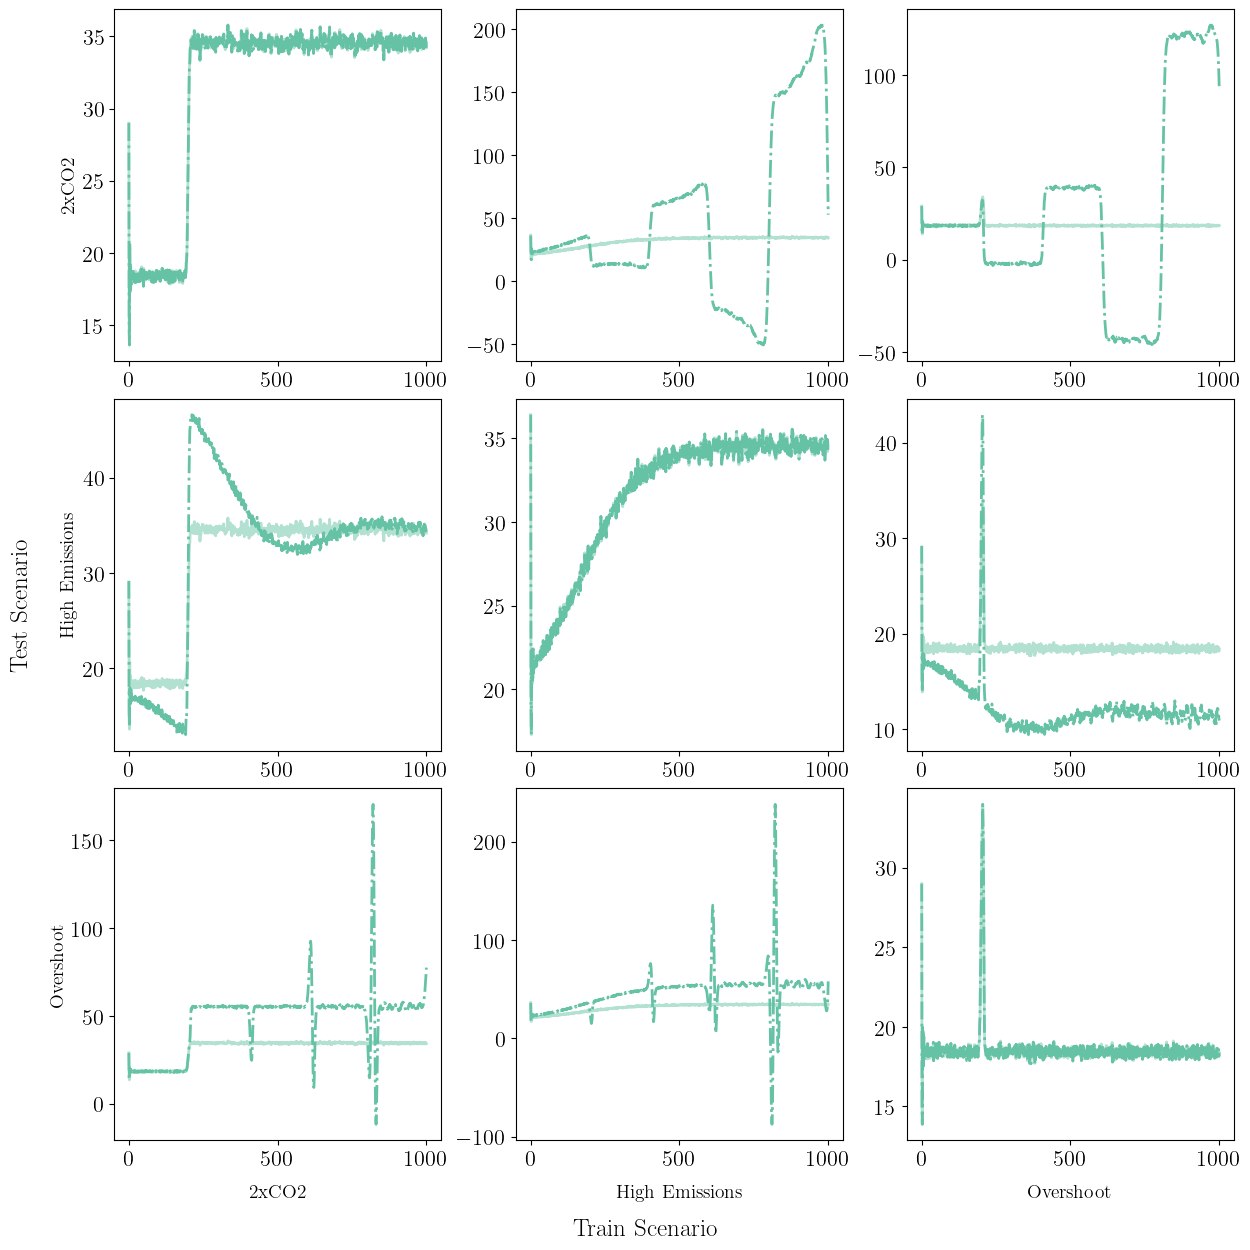

In [99]:
w0 = np.zeros(n_boxes)
#dt = 1
operator_deconvolve, z_pred_deconvolve, error_metrics_deconvolve = emulator_utils.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=z_mean, forcings=rho, dt=dt, regularize=False)
emulator_utils.plot_true_pred(z_mean, z_pred_deconvolve, scenarios)

### Method X: Exponential Fit

Train: 2xCO2 - L2 Error


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/jax/_src/ops/scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)
/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/jax/_src/ops/scatter.py

Step 0, cost=531.628357
Step 10, cost=427.774323
Step 20, cost=354.573639
Step 30, cost=247.323898
Step 40, cost=207.643448
Step 50, cost=169.544144
Step 60, cost=145.928864
Step 70, cost=130.680435
Step 80, cost=122.102737
Step 90, cost=116.129471
[-0.711677   -0.36042935  0.23022349]


/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:584: ComplexWarning: Casting complex values to real discards the imaginary part
  G_opt[:,i] = 1/alpha*jnp.exp(1/alpha*(lam + 1j*omega)*n)


	Test: 2xCO2 - [11.35986198]
	Test: High Emissions - [10.98510084]
	Test: Overshoot - [39.37411819]
Train: High Emissions - L2 Error


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/jax/_src/ops/scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


Step 0, cost=451.246948
Step 10, cost=368.144409
Step 20, cost=308.315918
Step 30, cost=231.217316
Step 40, cost=193.077271
Step 50, cost=172.259979
Step 60, cost=155.283829
Step 70, cost=143.018402
Step 80, cost=132.307419
Step 90, cost=124.184647
[-0.43994755 -0.550034    0.2597342 ]


/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:584: ComplexWarning: Casting complex values to real discards the imaginary part
  G_opt[:,i] = 1/alpha*jnp.exp(1/alpha*(lam + 1j*omega)*n)


	Test: 2xCO2 - [13.60553352]
	Test: High Emissions - [11.85887384]
	Test: Overshoot - [42.72145531]
Train: Overshoot - L2 Error


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/jax/_src/ops/scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


Step 0, cost=471.790009
Step 10, cost=209.283646
Step 20, cost=98.034386
Step 30, cost=67.862442
Step 40, cost=56.748638
Step 50, cost=54.466461
Step 60, cost=53.625751
Step 70, cost=53.347401
Step 80, cost=53.246326
Step 90, cost=53.130707
[-1.059925    0.5705663  -0.03259578]


/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:584: ComplexWarning: Casting complex values to real discards the imaginary part
  G_opt[:,i] = 1/alpha*jnp.exp(1/alpha*(lam + 1j*omega)*n)


	Test: 2xCO2 - [56.06902008]
	Test: High Emissions - [50.91443414]
	Test: Overshoot - [9.02692836]


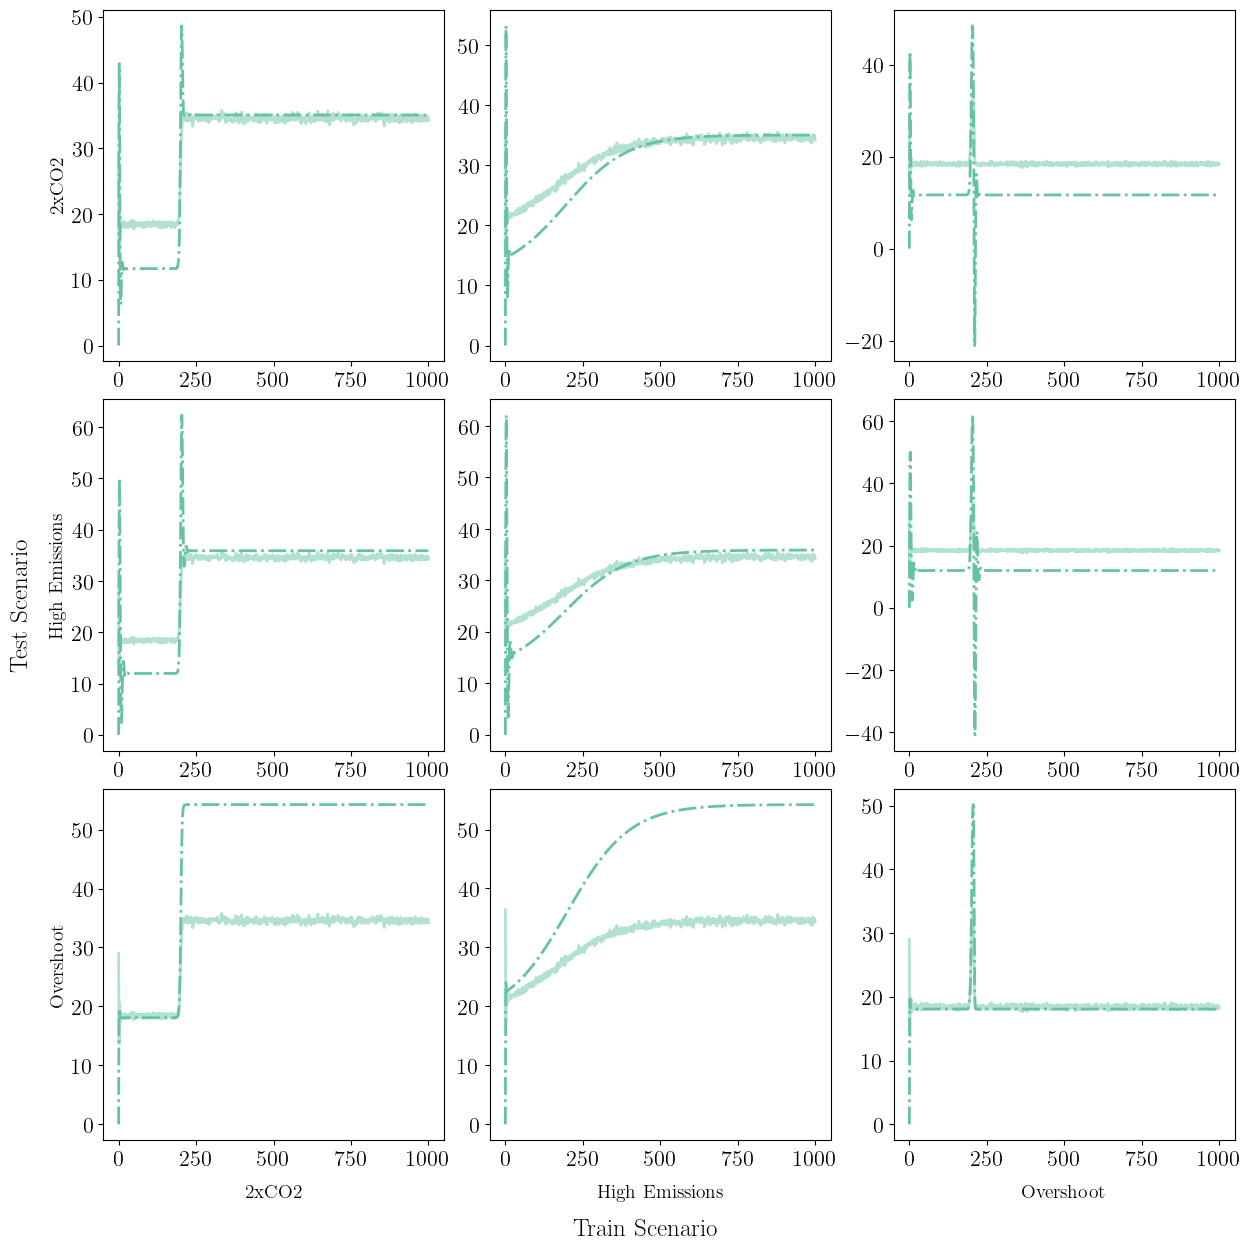

In [100]:
n_boxes = 1
operator_fit, T_pred_fit, error_metrics_fit = emulator_utils.emulate_scenarios('fit_complex', scenarios=scenarios, outputs=z_mean, forcings=rho, t=t_vec, dt=dt, n_boxes=n_boxes, n_modes=1)
emulator_utils.plot_true_pred(z_mean, T_pred_fit, scenarios)

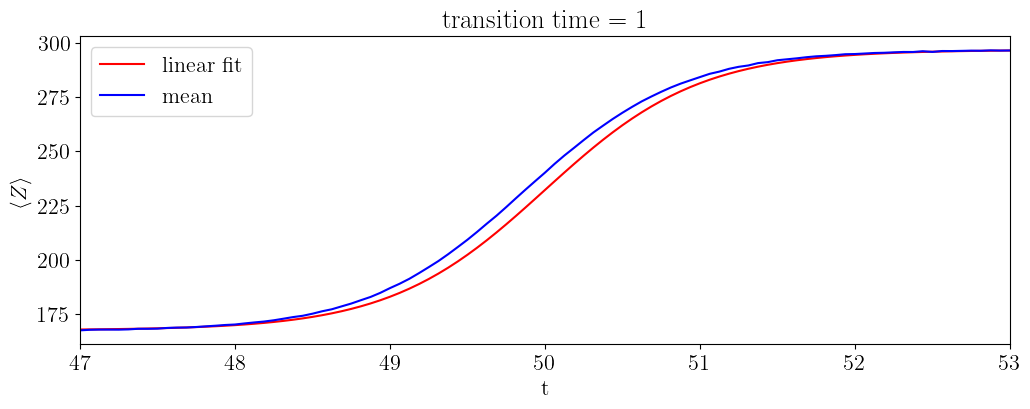

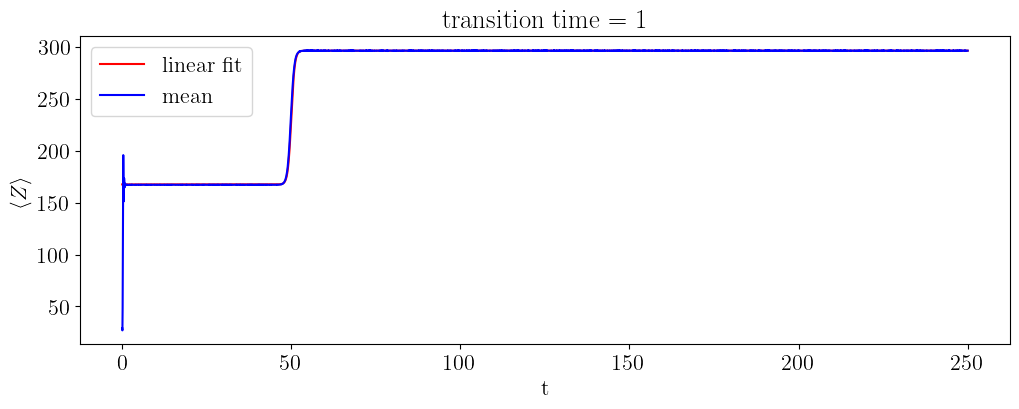

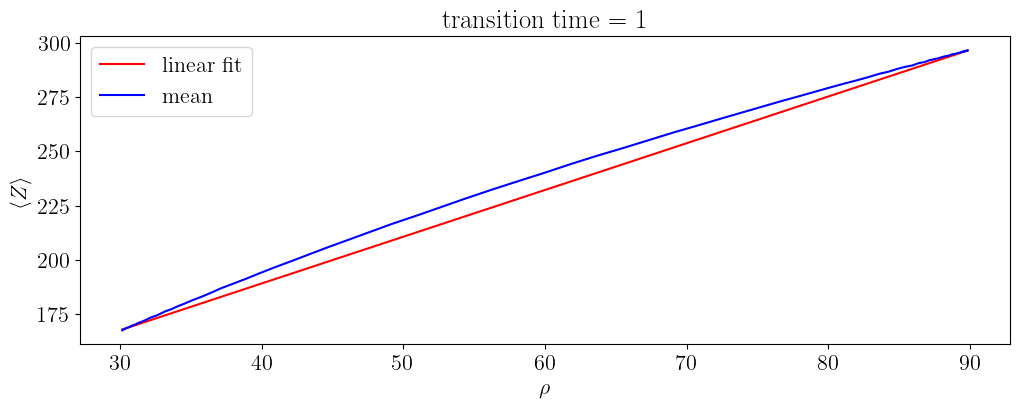

In [38]:
# 1) Create time array and compute rhos
rhos = emulator_utils.Lorenz_rho(t_vec, omega)

# 2) Linear fit for t >= 200
ind = np.where(t_vec >= 25)
p = np.polyfit(rhos[ind], x_mean['2xCO2'][ind], 1)   # slope & intercept
xfit = np.polyval(p, rhos)             # Evaluate the fit over all time

# 5) Restrict to region around tmax/2 ± 3*period
tmid = t_max/2
ind2 = np.where((t_vec >= 50 - 3*T) & (t_vec <= 50 + 3*T))[0]

# 6) Plot vs time
plt.figure()
plt.plot(t_vec[ind2], xfit[ind2], 'r', label='linear fit')
plt.plot(t_vec[ind2], x_mean['2xCO2'][ind2],   'b', label='mean')
plt.title(f"transition time = {T}")
plt.xlabel("t")
plt.ylabel(r"$\langle Z\rangle$")
plt.legend(loc='upper left')
plt.xlim([t_vec[ind2[0]], t_vec[ind2[-1]]])

plt.figure()
plt.plot(t_vec, xfit, 'r', label='linear fit')
plt.plot(t_vec, x_mean['2xCO2'],   'b', label='mean')
plt.title(f"transition time = {T}")
plt.xlabel("t")
plt.ylabel(r"$\langle Z\rangle$")
plt.legend(loc='upper left')

# 7) Plot vs rho
plt.figure()
plt.plot(rhos[ind2], xfit[ind2], 'r', label='linear fit')
plt.plot(rhos[ind2], x_mean['2xCO2'][ind2],   'b', label='mean')
plt.title(f"transition time = {T}")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\langle Z\rangle$")
plt.legend(loc='upper left')
#plt.savefig(f"cublort-fit-{period}-rho.png")

In [42]:
x_mean, rho

({'2xCO2': array([ 29.        ,  26.93467224,  48.48944625, ..., 296.67781901,
         296.62361024, 296.66553738], shape=(4001,)),
  'High Emissions': array([-1.90311558e-04,  1.53826949e-02,  5.82514197e-02, ...,
          7.58805107e+00,  7.69987254e+00,  7.63850884e+00], shape=(4001,)),
  'Overshoot': array([ 29.        ,  27.08520853,  48.66670521, ..., 167.27107907,
         167.35509315, 167.51972111], shape=(4001,))},
 {'2xCO2': array([30., 30., 30., ..., 90., 90., 90.], shape=(4001,)),
  'High Emissions': array([  0.99980969,   1.00106023,   1.00231234, ..., 148.01441539,
         148.1995491 , 148.38491436], shape=(4001,)),
  'Overshoot': array([30., 30., 30., ..., 30., 30., 30.], shape=(4001,))})